In [1]:
!pip install -q kaggle
!pip install pyyaml h5py

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhimanyuurs","key":"19b600612d996b9f82e8f9a246feb542"}'}

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 667M/675M [00:04<00:00, 180MB/s]
100% 675M/675M [00:04<00:00, 150MB/s]


In [ ]:
!unzip /content/cell-images-for-detecting-malaria.zip

In [7]:
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory

In [8]:
import os
import random
import shutil

folder_a_path = '/content/cell_images/cell_images'
folder_b_path = '/content/test'
num_images_to_select = 5000

for class_folder in os.listdir(folder_a_path):
    class_folder_path = os.path.join(folder_a_path, class_folder)
    if os.path.isdir(class_folder_path):
        class_b_subdir_path = os.path.join(folder_b_path, class_folder)
        os.makedirs(class_b_subdir_path, exist_ok=True)
        image_files = [f for f in os.listdir(class_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
        selected_images = random.sample(image_files, min(num_images_to_select, len(image_files)))
        for image in selected_images:
            src_path = os.path.join(class_folder_path, image)
            dst_path = os.path.join(class_b_subdir_path, image)
            shutil.move(src_path, dst_path)

In [9]:
trainp='/content/cell_images/cell_images'
testp='/content/test'

imagesize=(224,224)


train=image_dataset_from_directory(trainp,labels='inferred',label_mode='binary',color_mode='rgb',batch_size=32,
                                          validation_split=0.2,subset='training',image_size=imagesize,seed=53)
val=image_dataset_from_directory(trainp,labels='inferred',label_mode='binary',color_mode='rgb',batch_size=32,
                                          validation_split=0.2,subset='validation',image_size=imagesize,seed=53)
test=image_dataset_from_directory(testp,labels='inferred',label_mode='binary',color_mode='rgb',batch_size=32,
                                          image_size=imagesize,seed=53)


Found 17558 files belonging to 2 classes.
Using 14047 files for training.
Found 17558 files belonging to 2 classes.
Using 3511 files for validation.
Found 10000 files belonging to 2 classes.


In [10]:
from tensorflow.keras import layers

train = train.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y))
test = test.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y))
val = val.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y))

mobilelayer=tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='Max')

mobilelayer.trainable=False

x = layers.GlobalAveragePooling2D(name='avgpool')(mobilelayer.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(mobilelayer.input, x)

model.summary()
#tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [11]:
from keras.metrics import AUC,Precision,Recall,F1Score
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',AUC(),Precision(),Recall(),F1Score()],
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
history=model.fit(train,
    validation_data=val,
    epochs=15,
    callbacks=[callback])

Epoch 1/15
439/439 [==============================] - 44s 73ms/step - loss: 0.7867 - accuracy: 0.8904 - auc: 0.9477 - precision: 0.8809 - recall: 0.9026 - f1_score: 0.6642 - val_loss: 0.2083 - val_accuracy: 0.9285 - val_auc: 0.9803 - val_precision: 0.9058 - val_recall: 0.9576 - val_f1_score: 0.6696
Epoch 2/15
439/439 [==============================] - 26s 59ms/step - loss: 0.2172 - accuracy: 0.9167 - auc: 0.9704 - precision: 0.9061 - recall: 0.9294 - f1_score: 0.6663 - val_loss: 0.1697 - val_accuracy: 0.9396 - val_auc: 0.9824 - val_precision: 0.9385 - val_recall: 0.9417 - val_f1_score: 0.6696
Epoch 3/15
439/439 [==============================] - 25s 56ms/step - loss: 0.2143 - accuracy: 0.9213 - auc: 0.9711 - precision: 0.9104 - recall: 0.9343 - f1_score: 0.6665 - val_loss: 0.1985 - val_accuracy: 0.9353 - val_auc: 0.9795 - val_precision: 0.9176 - val_recall: 0.9576 - val_f1_score: 0.6696
Epoch 4/15
439/439 [==============================] - 25s 57ms/step - loss: 0.2098 - accuracy: 0.921

In [12]:
for layer in model.layers[-30:]:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',AUC(),Precision(),Recall(),F1Score()],
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

history2=model.fit(train,
    validation_data=val,
    epochs=15, callbacks=[callback])

Epoch 1/15
439/439 [==============================] - 32s 61ms/step - loss: 0.1577 - accuracy: 0.9431 - auc_1: 0.9836 - precision_1: 0.9360 - recall_1: 0.9511 - f1_score: 0.6664 - val_loss: 0.1374 - val_accuracy: 0.9499 - val_auc_1: 0.9883 - val_precision_1: 0.9354 - val_recall_1: 0.9672 - val_f1_score: 0.6705
Epoch 2/15
439/439 [==============================] - 27s 60ms/step - loss: 0.1371 - accuracy: 0.9522 - auc_1: 0.9870 - precision_1: 0.9439 - recall_1: 0.9614 - f1_score: 0.6679 - val_loss: 0.1313 - val_accuracy: 0.9516 - val_auc_1: 0.9891 - val_precision_1: 0.9380 - val_recall_1: 0.9677 - val_f1_score: 0.6707
Epoch 3/15
439/439 [==============================] - 26s 58ms/step - loss: 0.1264 - accuracy: 0.9554 - auc_1: 0.9892 - precision_1: 0.9464 - recall_1: 0.9652 - f1_score: 0.6688 - val_loss: 0.1291 - val_accuracy: 0.9533 - val_auc_1: 0.9897 - val_precision_1: 0.9440 - val_recall_1: 0.9643 - val_f1_score: 0.6711
Epoch 4/15
439/439 [==============================] - 26s 59ms/s

In [14]:
model.save_weights('/content/gdrive/MyDrive/mobilenetweights2LATEST.h5')
model.save('/content/gdrive/MyDrive/mobilenet2LATESt.keras')

In [15]:
train = train.map(lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y))
test = test.map(lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y))
val = val.map(lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y))

enlayer=tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='Max')

x = tf.keras.layers.GlobalAveragePooling2D(name='avgpool')(enlayer.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(enlayer.input, x)


model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)   

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',AUC(),Precision(),Recall(),F1Score()],
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
history3=model.fit(train,
    validation_data=val,
    epochs=15, callbacks=[callback])

Epoch 1/15
439/439 [==============================] - 109s 154ms/step - loss: 0.2634 - accuracy: 0.9400 - auc_2: 0.9667 - precision_2: 0.9309 - recall_2: 0.9504 - f1_score: 0.6666 - val_loss: 0.7831 - val_accuracy: 0.5033 - val_auc_2: 0.4151 - val_precision_2: 0.5033 - val_recall_2: 1.0000 - val_f1_score: 0.6696
Epoch 2/15
439/439 [==============================] - 61s 138ms/step - loss: 0.1791 - accuracy: 0.9492 - auc_2: 0.9763 - precision_2: 0.9387 - recall_2: 0.9609 - f1_score: 0.6752 - val_loss: 5.8693 - val_accuracy: 0.4967 - val_auc_2: 0.5000 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.6696
Epoch 3/15
439/439 [==============================] - 61s 137ms/step - loss: 0.1396 - accuracy: 0.9570 - auc_2: 0.9845 - precision_2: 0.9419 - recall_2: 0.9739 - f1_score: 0.6684 - val_loss: 0.8063 - val_accuracy: 0.5033 - val_auc_2: 0.6900 - val_precision_2: 0.5033 - val_recall_2: 1.0000 - val_f1_score: 0.6696
Epoch 4/15
439/439 [==============================] 

In [17]:
for layer in model.layers[-30:]:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',AUC(),Precision(),Recall(),F1Score()],
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
history4=model.fit(train,
    validation_data=val,
    epochs=15, callbacks=[callback])

Epoch 1/15
439/439 [==============================] - 103s 155ms/step - loss: 0.2284 - accuracy: 0.9379 - auc_3: 0.9749 - precision_3: 0.9355 - recall_3: 0.9405 - f1_score: 0.7051 - val_loss: 0.1779 - val_accuracy: 0.9504 - val_auc_3: 0.9832 - val_precision_3: 0.9403 - val_recall_3: 0.9626 - val_f1_score: 0.7106
Epoch 2/15
439/439 [==============================] - 66s 150ms/step - loss: 0.2052 - accuracy: 0.9416 - auc_3: 0.9775 - precision_3: 0.9368 - recall_3: 0.9468 - f1_score: 0.6999 - val_loss: 0.1630 - val_accuracy: 0.9536 - val_auc_3: 0.9842 - val_precision_3: 0.9407 - val_recall_3: 0.9689 - val_f1_score: 0.7043
Epoch 3/15
439/439 [==============================] - 61s 138ms/step - loss: 0.1933 - accuracy: 0.9435 - auc_3: 0.9786 - precision_3: 0.9375 - recall_3: 0.9501 - f1_score: 0.6949 - val_loss: 0.1578 - val_accuracy: 0.9530 - val_auc_3: 0.9846 - val_precision_3: 0.9396 - val_recall_3: 0.9689 - val_f1_score: 0.6999
Epoch 4/15
439/439 [==============================] - 60s 13

In [19]:
model.save_weights('/content/gdrive/MyDrive/effinetLATEST.h5')
model.save('/content/gdrive/MyDrive/effinetLATESt.keras')

In [20]:
train = train.map(lambda x, y: (tf.keras.applications.nasnet.preprocess_input(x), y))
test = test.map(lambda x, y: (tf.keras.applications.nasnet.preprocess_input(x), y))
val = val.map(lambda x, y: (tf.keras.applications.nasnet.preprocess_input(x), y))

naslayer=tf.keras.applications.NASNetMobile(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='Max')

x = layers.GlobalAveragePooling2D(name='avgpool')(naslayer.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(naslayer.input, x)


model.summary()

19993432/19993432 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)   

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',AUC(),Precision(),Recall(),F1Score()],
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
history5=model.fit(train,
    validation_data=val,
    epochs=15, callbacks=[callback])

Epoch 1/15
439/439 [==============================] - 241s 231ms/step - loss: 0.4696 - accuracy: 0.7944 - auc_4: 0.8963 - precision_4: 0.8076 - recall_4: 0.7721 - f1_score: 0.6745 - val_loss: 761087131648.0000 - val_accuracy: 0.4967 - val_auc_4: 0.5000 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/15
439/439 [==============================] - 92s 208ms/step - loss: 0.1626 - accuracy: 0.9512 - auc_4: 0.9758 - precision_4: 0.9529 - recall_4: 0.9491 - f1_score: 0.6691 - val_loss: 54867372.0000 - val_accuracy: 0.4967 - val_auc_4: 0.5000 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/15
439/439 [==============================] - 90s 204ms/step - loss: 0.1572 - accuracy: 0.9564 - auc_4: 0.9749 - precision_4: 0.9488 - recall_4: 0.9648 - f1_score: 0.6731 - val_loss: 23593974.0000 - val_accuracy: 0.4967 - val_auc_4: 0.5000 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_f1_score: 0.0000e+00

In [22]:
for layer in model.layers[-30:]:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',AUC(),Precision(),Recall(),F1Score()],
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)
history6=model.fit(train,
    validation_data=val,
    epochs=15, callbacks=[callback])

Epoch 1/15
439/439 [==============================] - 228s 227ms/step - loss: 0.1334 - accuracy: 0.9586 - auc_5: 0.9822 - precision_5: 0.9535 - recall_5: 0.9641 - f1_score: 0.6718 - val_loss: 244576.7188 - val_accuracy: 0.4967 - val_auc_5: 0.5000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/15
439/439 [==============================] - 95s 216ms/step - loss: 0.1313 - accuracy: 0.9586 - auc_5: 0.9823 - precision_5: 0.9515 - recall_5: 0.9662 - f1_score: 0.6712 - val_loss: 18581.5898 - val_accuracy: 0.4967 - val_auc_5: 0.5000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/15
439/439 [==============================] - 91s 205ms/step - loss: 0.1302 - accuracy: 0.9583 - auc_5: 0.9826 - precision_5: 0.9511 - recall_5: 0.9661 - f1_score: 0.6706 - val_loss: 2641.8721 - val_accuracy: 0.4967 - val_auc_5: 0.5000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/15
4

In [24]:
model.save_weights('/content/gdrive/MyDrive/nasnetweights2LATEST.h5')
model.save('/content/gdrive/MyDrive/nasnet2LATESt.keras')

ValueError: x, y, and format string must not be None

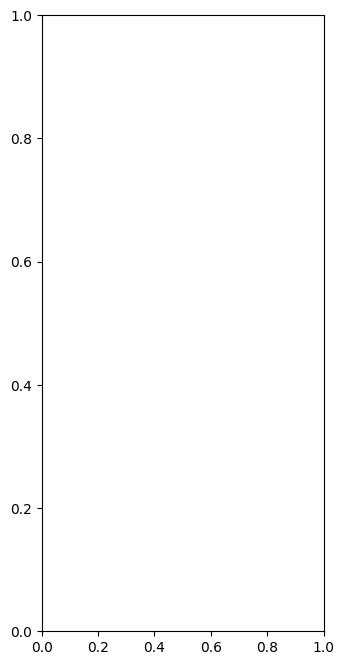

In [25]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

acc= acc.extend(history2.history['accuracy'])
val_acc= val_acc.extend(history2.history['accuracy'])

loss = history.history['loss']
val_loss = history.history['val_loss']

loss = loss.extend(history2.history['loss'])
val_loss = val_loss.extend(history2.history['val_loss'])

epochs_range = 30

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

acc= acc.extend(history4.history['accuracy'])
val_acc= val_acc.extend(history4.history['accuracy'])

loss = history3.history['loss']
val_loss = history3.history['val_loss']

loss = loss.extend(history4.history['loss'])
val_loss = val_loss.extend(history4.history['val_loss'])

epochs_range = 30

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

acc= acc.extend(history6.history['accuracy'])
val_acc= val_acc.extend(history6.history['accuracy'])

loss = history5.history['loss']
val_loss = history5.history['val_loss']

loss = loss.extend(history6.history['loss'])
val_loss = val_loss.extend(history6.history['val_loss'])

epochs_range = 30

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Testing**

In [26]:
test_dataset = test.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y))
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.load_model('/content/gdrive/MyDrive/mobilenet2LATESt.keras')

model.evaluate(test_dataset)

313/313 [==============================] - 21s 59ms/step - loss: 0.6932 - accuracy: 0.5000 - auc_1: 0.5000 - precision_1: 0.5000 - recall_1: 1.0000 - f1_score: 0.6667


[0.6932079195976257, 0.5, 0.5, 0.5, 1.0, array([0.6666667], dtype=float32)]

In [27]:
test_dataset = test.map(lambda x, y: (tf.keras.applications.efficientnet.preprocess_input(x), y))
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.load_model('/content/gdrive/MyDrive/effinetLATESt.keras')

model.evaluate(test_dataset)

313/313 [==============================] - 19s 50ms/step - loss: 1.1511 - accuracy: 0.5000 - auc_3: 0.5001 - precision_3: 0.5000 - recall_3: 1.0000 - f1_score: 0.6667


[1.151136875152588,
 0.5,
 0.5001000165939331,
 0.5,
 1.0,
 array([0.6666667], dtype=float32)]

In [28]:
test_dataset = test.map(lambda x, y: (tf.keras.applications.nasnet.preprocess_input(x), y))
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.load_model('/content/gdrive/MyDrive/nasnet2LATESt.keras')

model.evaluate(test_dataset)

313/313 [==============================] - 28s 67ms/step - loss: 562.4911 - accuracy: 0.5000 - auc_5: 0.5000 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.0000e+00


[562.4911499023438, 0.5, 0.5, 0.0, 0.0, array([0.], dtype=float32)]